In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *
from bnbsl import *

from classes import *
from utils import *

In [3]:
SEASON = '23'
set_seed(int(SEASON))

## Download HKJC odds

In [4]:
path_raw = Path('raw_data')
path_data = Path('data')

path_output = Path('output')

In [5]:
session = requests.Session()
r = session.get('http://bet.hkjc.com')
cookies = r.cookies

In [6]:
odds_url = 'https://bet.hkjc.com/football/getJSON.aspx?jsontype=odds_chl.aspx'
response = session.post(
    odds_url,
    headers={'referer':'http://bet.hkjc.com'},
    cookies=cookies
)

In [7]:
with open(path_data/'json'/f'odds_chl-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.txt', 'w') as f:
    f.write(response.text)

In [8]:
matches_json = json.loads(response.text)['matches']

In [9]:
# Example
# matches_json = json.loads(open(path_data/'json'/'odds_chl-2021-11-20-20-15-14.txt').read())[1]['matches']

In [10]:
matches = [Match(m) for m in matches_json if m['matchStatus'] == 'Defined']
odds = [m.export() for m in matches]

['20230818FRIFB4361', '2023-Aug-18', '18:00:00', 'Japanese Division 1 [JD1]', 'Avispa Fukuoka', 'Albirex Niigata', 'true', '9.5', '2.00', '1.72', 'false', '10.5', '2.58', '1.44', 'false', '12.5', '4.40', '1.16']
['20230818FRIFB4385', '2023-Aug-18', '18:30:00', 'Japanese Division 1 [JD1]', 'Urawa Reds', 'Nagoya Grampus', 'true', '9.5', '1.70', '2.02', 'false', '10.5', '2.12', '1.64', 'false', '13.5', '4.55', '1.15']
['20230818FRIFB4363', '2023-Aug-18', '18:30:00', 'Korean Division 1 [KD1]', 'Suwon Bluewings', 'Jeju Utd', 'true', '8.5', '1.84', '1.86', 'false', '11.5', '3.90', '1.20', 'false', '9.5', '2.30', '1.54']
['20230818FRIFB4362', '2023-Aug-18', '18:30:00', 'Korean Division 1 [KD1]', 'Incheon Utd', 'Gwangju FC', 'true', '8.5', '1.93', '1.77', 'false', '11.5', '4.30', '1.17', 'false', '9.5', '2.48', '1.47']
['20230818FRIFB4384', '2023-Aug-18', '23:00:00', 'Finnish Division 1 [FVL]', 'Lahti', 'VPS Vaasa', 'true', '9.5', '1.79', '1.91', 'false', '10.5', '2.25', '1.57', 'false', '13.5

In [11]:
cols_match = ['MatchDay', 'Date', 'Time', 'LeagueJC', 'HomeTeamJC', 'AwayTeamJC']
cols_odds0 = ['MAINLINE_0', 'CHL_LINE_0', 'CHL_H_0', 'CHL_L_0']
cols_odds1 = ['MAINLINE_1', 'CHL_LINE_1', 'CHL_H_1', 'CHL_L_1']
cols_odds2 = ['MAINLINE_2', 'CHL_LINE_2', 'CHL_H_2', 'CHL_L_2']
cols_odds  = ['MAINLINE', 'CHL_LINE', 'CHL_H', 'CHL_L']
cols_pred  = ['alpha_1', 'alpha_2', 'mu_1', 'mu_2', 'omega', 'corr']

cols = cols_match + cols_odds0 + cols_odds1 + cols_odds2

In [12]:
odds = [o for o in odds if len(o) == 18]

In [13]:
odds = pd.DataFrame(odds, columns=cols)
odds = odds.fillna(value=np.nan)

In [14]:
cols_odds_ = cols_odds0[1:]+cols_odds1[1:]+cols_odds2[1:]
odds[cols_odds_] = odds[cols_odds_].astype(float)

In [15]:
odds

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE_0,CHL_LINE_0,CHL_H_0,CHL_L_0,MAINLINE_1,CHL_LINE_1,CHL_H_1,CHL_L_1,MAINLINE_2,CHL_LINE_2,CHL_H_2,CHL_L_2
0,20230818FRIFB4361,2023-Aug-18,18:00:00,Japanese Division 1 [JD1],Avispa Fukuoka,Albirex Niigata,true,9.5,2.00,1.72,false,10.5,2.58,1.44,false,12.5,4.40,1.16
1,20230818FRIFB4385,2023-Aug-18,18:30:00,Japanese Division 1 [JD1],Urawa Reds,Nagoya Grampus,true,9.5,1.70,2.02,false,10.5,2.12,1.64,false,13.5,4.55,1.15
2,20230818FRIFB4363,2023-Aug-18,18:30:00,Korean Division 1 [KD1],Suwon Bluewings,Jeju Utd,true,8.5,1.84,1.86,false,11.5,3.90,1.20,false,9.5,2.30,1.54
3,20230818FRIFB4362,2023-Aug-18,18:30:00,Korean Division 1 [KD1],Incheon Utd,Gwangju FC,true,8.5,1.93,1.77,false,11.5,4.30,1.17,false,9.5,2.48,1.47
4,20230818FRIFB4384,2023-Aug-18,23:00:00,Finnish Division 1 [FVL],Lahti,VPS Vaasa,true,9.5,1.79,1.91,false,10.5,2.25,1.57,false,13.5,4.90,1.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,20230822TUEFB4452,2023-Aug-22,00:30:00,Italian Division 1 [ISA],AC Torino,Cagliari,true,9.5,2.00,1.72,false,10.5,2.55,1.45,false,12.5,4.40,1.16
91,20230822TUEFB4435,2023-Aug-22,01:00:00,Spanish Division 1 [SFL],Alaves,Sevilla,true,9.5,2.15,1.62,false,10.5,2.80,1.38,false,12.5,4.90,1.13
92,20230822TUEFB4450,2023-Aug-22,02:45:00,Italian Division 1 [ISA],Bologna,AC Milan,true,9.5,1.95,1.75,false,10.5,2.45,1.48,false,12.5,4.25,1.17
93,20230822TUEFB4430,2023-Aug-22,03:00:00,Eng Premier [EPL],Crystal Palace,Arsenal,true,10.5,2.08,1.66,false,11.5,2.68,1.41,false,13.5,4.75,1.14


In [16]:
odds['MatchDay'] = odds['MatchDay'].str[8:]
odds['Date'] = pd.to_datetime(odds['Date'])
odds['Time'] = pd.to_datetime(odds['Time'], format='%H:%M:%S').dt.time

In [17]:
odds['DateTimeJC'] = pd.to_datetime(odds['Date'].dt.date.map(str) + '-' + odds['Time'].map(str))
odds['DateTimeJC'] = odds['DateTimeJC'].dt.tz_localize('Hongkong')
odds['DateTime'] = odds['DateTimeJC'].dt.tz_convert('GB')

In [18]:
map_league = pd.read_csv(path_data/'league.csv')
map_team = pd.read_csv(path_data/'team.csv')

In [19]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2', 'UCL', 'UEC', 'UEF']
map_league = map_league[map_league.Div.isin(div)].reset_index(drop=True)

In [20]:
# Map Div name
odds = odds.merge(map_league[['LeagueJC', 'Div']], 'inner', on='LeagueJC')

In [21]:
# Map Team name
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'HomeTeam'}), 'inner', 
                  left_on='HomeTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'AwayTeam'}), 'inner', 
                  left_on='AwayTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])

## Download recent stats

In [22]:
# Download latest results in current season
!wget -q https://www.football-data.co.uk/mmz4281/{SEASON}{int(SEASON)+1}/data.zip -O raw_data/data.zip

# Unzip to folder
!unzip -q -o raw_data/data.zip -d raw_data/{SEASON}

In [23]:
usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'HC', 'AC', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST']
dtype = {'HC':'float', 'AC':'float'}
parse_dates = ['Date']

seasons = [SEASON]

dfs = []

for folder in sorted(path_raw.iterdir()):
    if folder.is_dir() and folder.name in seasons: 
        for file in sorted(folder.glob('*.csv')):
            try:
                df = pd.read_csv(file, usecols=usecols, dtype=dtype, parse_dates=parse_dates, dayfirst=True)
                df['Season'] = folder.name
                dfs.append(df)
            except:
                continue

In [24]:
df_season = pd.concat(dfs)
df_season = df_season.dropna()
df_season = df_season.sort_values(['Div', 'Date', 'HomeTeam']).reset_index(drop=True)

In [25]:
df_hist = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])
df_hist = df_hist.query(f'Season == {int(SEASON)-1}').reset_index(drop=True)

In [26]:
df_season = pd.concat([df_hist[df_season.columns], df_season])

In [27]:
# Make features on historical stats (Home and Away)
stats = ['FTHG', 'HS', 'HST', 'HC', 'FTAG', 'AS', 'AST', 'AC']
df_home, df_away = joinLastGamesStatsHomeAway(df_season, stats)

In [28]:
# Make features on historical stats (For and Against)
stats = [('FTHG', 'FTAG', 'FTG'), ('HS', 'AS', 'S'), ('HST', 'AST', 'ST'), ('HC', 'AC', 'C')]
df_for, df_against = joinLastGamesStatsForAgainst(df_season, stats)

In [29]:
df_home = df_home.sort_values(['HomeTeam', 'Date']).reset_index(drop=True)
df_away = df_away.sort_values(['AwayTeam', 'Date']).reset_index(drop=True)

df_home = df_home.groupby('HomeTeam')[df_home.columns[df_home.columns.str.contains('Avg')]].last().reset_index()
df_away = df_away.groupby('AwayTeam')[df_away.columns[df_away.columns.str.contains('Avg')]].last().reset_index()

In [30]:
odds = odds.merge(df_home, 'left', 'HomeTeam').merge(df_away, 'left', 'AwayTeam')

In [31]:
cols_home = df_for.columns[df_for.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_for.columns[df_for.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_for = df_for.groupby('Team')[df_for.columns[df_for.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_for.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_for.rename(columns=cols_away), 'left', 'AwayTeam')

In [32]:
cols_home = df_against.columns[df_against.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_against.columns[df_against.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_against = df_against.groupby('Team')[df_against.columns[df_against.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_against.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_against.rename(columns=cols_away), 'left', 'AwayTeam')

In [33]:
add_datepart(odds, 'DateTime', prefix='', drop=False);

In [34]:
display_df(odds.head(5).T)

,0,1,2,3,4
MatchDay,SATFB4369,SATFB4463,SATFB4461,SATFB4460,SUNFB4464
Date,2023-08-19 00:00:00,2023-08-19 00:00:00,2023-08-19 00:00:00,2023-08-19 00:00:00,2023-08-20 00:00:00
Time,00:30:00,19:00:00,19:00:00,19:00:00,02:30:00
LeagueJC,German Division 2 [GD2],German Division 2 [GD2],German Division 2 [GD2],German Division 2 [GD2],German Division 2 [GD2]
HomeTeamJC,Wehen,Dusseldorf,Greuther Furth,Rostock,Hamburg
AwayTeamJC,Karlsruher,Paderborn,St. Pauli,Hannover,Hertha Berlin
MAINLINE_0,true,true,true,true,true
CHL_LINE_0,10.5,9.5,9.5,10.5,10.5
CHL_H_0,2.08,1.75,1.92,2.05,2.02
CHL_L_0,1.66,1.95,1.78,1.68,1.7


## Load model

In [37]:
learn_bnb = load_learner('models/learn_bnbsl.pkl')

In [38]:
to = load_pandas('models/to.pkl')

In [39]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [40]:
odds = odds.dropna(how='any')

In [41]:
to_tst = to.new(odds)
to_tst.process()
# to_tst.items.head()

In [42]:
tst_dl = learn_bnb.dls.valid.new(to_tst)
tst_dl.show(max_n=999)

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
1,D2,Fortuna Dusseldorf,Paderborn,15.0,4.6,12.2,3.8,10.8,14.0,15.0,15.8
2,D2,Greuther Furth,St Pauli,12.8,5.8,13.2,4.2,14.8,14.4,10.2,10.2
3,D2,Hansa Rostock,Hannover,13.2,5.8,9.6,4.6,11.4,12.4,13.2,15.2
4,D2,Hamburg,Hertha,14.8,6.0,8.2,3.4,16.2,10.2,11.8,17.8
6,D2,Braunschweig,Schalke 04,15.8,6.2,11.8,5.4,10.8,12.2,15.2,17.6
7,D2,Holstein Kiel,Magdeburg,15.0,4.4,12.4,3.4,13.2,12.6,11.0,13.4
8,SP1,Mallorca,Villarreal,7.8,2.8,13.4,3.6,6.0,13.8,17.8,12.0
9,SP1,Valencia,Las Palmas,13.8,6.6,10.4,5.0,13.6,12.8,8.8,12.8
10,SP1,Sociedad,Celta,13.2,5.4,10.0,5.0,14.6,11.0,9.6,11.0
11,SP1,Almeria,Real Madrid,13.4,3.8,16.4,6.6,11.2,11.2,12.0,12.4


In [43]:
pred, _ = learn_bnb.get_preds(dl=tst_dl)

In [44]:
alpha = F.softplus(pred[:, 0:2])
mu = F.softplus(pred[:, 2:4])
omega = pred[:, 4]

total_count = 1. / alpha
logits = torch.log(alpha * mu)

# print(alpha, mu, omega)

In [45]:
# Method 1:
corr = omega * torch.sqrt(mu.prod(-1)) * alpha.prod(-1) / ((1.+alpha)**(1./alpha+1.)).prod(-1) / torch.sqrt((1.+alpha*mu).prod(-1))

In [46]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod(-1)*(1.+alpha*mu).prod(-1)) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod(-1)

In [47]:
odds[cols_pred] = torch.cat([alpha, mu, omega.unsqueeze(-1), corr.unsqueeze(-1)], dim=-1)

In [48]:
odds0 = odds[cols_match+cols_odds0+cols_pred].rename(columns=dict(zip(cols_odds0, cols_odds)))
odds1 = odds[cols_match+cols_odds1+cols_pred].rename(columns=dict(zip(cols_odds1, cols_odds)))
odds2 = odds[cols_match+cols_odds2+cols_pred].rename(columns=dict(zip(cols_odds2, cols_odds)))

In [49]:
odds = pd.concat([odds0, odds1, odds2]).dropna().reset_index(drop=True)
odds['MAINLINE'] = np.where(odds['MAINLINE']=='true', True, False)

In [50]:
odds.head(5)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,alpha_1,alpha_2,mu_1,mu_2,omega,corr
0,SATFB4463,2023-08-19,19:00:00,German Division 2 [GD2],Dusseldorf,Paderborn,True,9.5,1.75,1.95,0.077238,0.079824,4.795452,4.363761,-47.182243,-0.122725
1,SATFB4461,2023-08-19,19:00:00,German Division 2 [GD2],Greuther Furth,St. Pauli,True,9.5,1.92,1.78,0.069983,0.090935,5.510677,4.108681,-51.643589,-0.141846
2,SATFB4460,2023-08-19,19:00:00,German Division 2 [GD2],Rostock,Hannover,True,10.5,2.05,1.68,0.080373,0.057064,5.597746,5.304892,-55.881977,-0.128600
3,SUNFB4464,2023-08-20,02:30:00,German Division 2 [GD2],Hamburg,Hertha Berlin,True,10.5,2.02,1.70,0.049409,0.103755,7.355101,3.897102,-62.411438,-0.155509
4,SUNFB4459,2023-08-20,19:30:00,German Division 2 [GD2],Braunschweig,Schalke 04,True,10.5,1.98,1.73,0.075264,0.073030,5.582551,4.776214,-53.205929,-0.137354


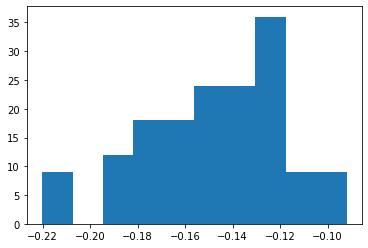

In [51]:
odds['corr'].hist(grid=False);

In [52]:
prob_hilo = []

for r in list(zip(odds['alpha_1'], odds['alpha_2'], odds['mu_1'], odds['mu_2'], odds['omega'], odds['CHL_LINE'])):
    total_count = 1. / torch.tensor(r[0:2], device='cpu') 
    logits = torch.log(torch.tensor(r[0:2], device='cpu') * torch.tensor(r[2:4], device='cpu'))
    omega = torch.tensor(r[4], device='cpu')

    bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)
    value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))
    corner = bnb_corner.log_prob(value).exp()
    
    line = r[5]
    mask = value.sum(-1) < line
    prob_lo = corner[mask].sum()
    prob_hi = 1 - prob_lo
    
    prob_hilo.append([prob_hi.item(), prob_lo.item()])

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [53]:
odds[['prob_hi', 'prob_lo']] = prob_hilo

In [54]:
odds['kelly_hi'] = (odds['prob_hi'] * odds['CHL_H'] - 1) / (odds['CHL_H'] - 1)
odds['kelly_lo'] = (odds['prob_lo'] * odds['CHL_L'] - 1) / (odds['CHL_L'] - 1)

In [55]:
odds['kelly'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], odds['kelly_hi'], odds['kelly_lo']), 
    np.nan
)

In [56]:
odds['bet'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], 'High', 'Low'), 
    None
)

In [57]:
odds = odds.sort_values('kelly', ascending=False).reset_index(drop=True)

In [58]:
odds['selected'] = np.where(
    odds['MAINLINE']==True, np.where(
        odds['kelly']>0.35, '$$$', np.where(
            odds['kelly']>0.25, '$$', np.where(
                odds['kelly']>0.15, '$', None))), 
    None
)

In [59]:
odds = odds.drop(columns=cols_pred+['kelly_hi', 'kelly_lo'])

In [60]:
odds[odds.bet.notna() & odds.selected.notna()]

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
4,TUEFB4430,2023-08-22,03:00:00,Eng Premier [EPL],Crystal Palace,Arsenal,True,10.5,2.08,1.66,0.285247,0.714753,0.282561,Low,$$
5,TUEFB4437,2023-08-22,03:30:00,Spanish Division 1 [SFL],CF Granada,Vallecano,True,9.5,1.95,1.75,0.315954,0.684046,0.262773,Low,$$
10,MONFB4431,2023-08-21,01:00:00,Spanish Division 1 [SFL],Girona,Getafe,True,8.5,2.01,1.71,0.329607,0.670393,0.206157,Low,$
12,SATFB4364,2023-08-19,02:45:00,Eng Premier [EPL],Nottingham Forest,Sheff Utd,True,10.5,2.12,1.64,0.314755,0.685245,0.193441,Low,$
13,SUNFB4432,2023-08-20,03:30:00,Spanish Division 1 [SFL],Osasuna,Bilbao,True,9.5,1.86,1.84,0.370531,0.629469,0.188361,Low,$
15,SATFB4446,2023-08-19,21:30:00,German Division 1 [GSL],Hoffenheim,Freiburg,True,9.5,1.86,1.84,0.614238,0.385762,0.165677,High,$


In [61]:
display_df(odds[odds.MatchDay.isin(odds[odds.bet.notna() & odds.selected.notna()].MatchDay) & odds.bet.notna()])

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,TUEFB4437,2023-08-22,03:30:00,Spanish Division 1 [SFL],CF Granada,Vallecano,False,12.5,4.30,1.17,0.092680,0.907320,0.362144,Low,None
1,TUEFB4430,2023-08-22,03:00:00,Eng Premier [EPL],Crystal Palace,Arsenal,False,13.5,4.75,1.14,0.083829,0.916171,0.317390,Low,None
2,TUEFB4430,2023-08-22,03:00:00,Eng Premier [EPL],Crystal Palace,Arsenal,False,11.5,2.68,1.41,0.198563,0.801437,0.317138,Low,None
3,TUEFB4437,2023-08-22,03:30:00,Spanish Division 1 [SFL],CF Granada,Vallecano,False,10.5,2.50,1.46,0.220343,0.779657,0.300649,Low,None
4,TUEFB4430,2023-08-22,03:00:00,Eng Premier [EPL],Crystal Palace,Arsenal,True,10.5,2.08,1.66,0.285247,0.714753,0.282561,Low,$$
5,TUEFB4437,2023-08-22,03:30:00,Spanish Division 1 [SFL],CF Granada,Vallecano,True,9.5,1.95,1.75,0.315954,0.684046,0.262773,Low,$$
6,SUNFB4432,2023-08-20,03:30:00,Spanish Division 1 [SFL],Osasuna,Bilbao,False,13.5,5.30,1.11,0.075188,0.924812,0.241284,Low,None
7,MONFB4431,2023-08-21,01:00:00,Spanish Division 1 [SFL],Girona,Getafe,False,9.5,2.68,1.41,0.226715,0.773285,0.220321,Low,None
8,SATFB4364,2023-08-19,02:45:00,Eng Premier [EPL],Nottingham Forest,Sheff Utd,False,11.5,2.70,1.40,0.223603,0.776397,0.217389,Low,None
9,SUNFB4432,2023-08-20,03:30:00,Spanish Division 1 [SFL],Osasuna,Bilbao,False,10.5,2.38,1.51,0.266874,0.733126,0.209842,Low,None


In [62]:
odds[odds.MAINLINE].to_csv(path_output/f'odds-{datetime.now().strftime("%Y-%m-%d")}.csv', float_format='%.2f', index=False)